In [1]:
import os
import re
from string import punctuation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import ConfusionMatrixDisplay
import torch
from torch import nn

In [2]:
ROOT_PATH = os.path.split(os.getcwd())[0]
ROOT_PATH

'/home/vsg/repos/manifesto'

In [3]:
DATA_DIR = os.path.join(ROOT_PATH, 'data')
MAIN_DATASET = os.path.join(DATA_DIR, 'MPDataset_MPDS2021a.csv')
PARTY_DATASET = os.path.join(DATA_DIR, 'parties_MPDataset_MPDS2021a.csv')
RAW_DIR = os.path.join(DATA_DIR, 'raw')

In [4]:
df_main = pd.read_csv(MAIN_DATASET)
df_main.head()

,country,countryname,oecdmember,eumember,edate,date,party,partyname,partyabbrev,parfam,...,per608_3,per703_1,per703_2,rile,planeco,markeco,welfare,intpeace,datasetversion,id_perm
0,11,Sweden,0,0,17/09/1944,194409,11220,Communist Party of Sweden,SKP,20,...,NaN,NaN,NaN,9.60,1.9,1.900,0.0,1.900,2021a,JN1LZH
1,11,Sweden,0,0,17/09/1944,194409,11320,Social Democratic Labour Party,SAP,30,...,NaN,NaN,NaN,-37.80,3.3,2.200,33.4,5.600,2021a,CMR7F6
2,11,Sweden,0,0,17/09/1944,194409,11420,People’s Party,FP,40,...,NaN,NaN,NaN,9.50,3.2,6.400,14.3,1.600,2021a,Z6OL6C
3,11,Sweden,0,0,17/09/1944,194409,11620,Right Party,NaN,60,...,NaN,NaN,NaN,28.00,1.8,22.800,10.6,0.000,2021a,YMKVN2
4,11,Sweden,0,0,17/09/1944,194409,11810,Agrarian Party,NaN,80,...,NaN,NaN,NaN,23.81,0.0,19.048,0.0,4.762,2021a,U4SCRD


In [5]:
df_parties = pd.read_csv(PARTY_DATASET)
df_parties.head()

,country,countryname,party,abbrev,name,name_english,year_min,year_max,is_alliance,max_pervote,max_presvote
0,11,Sweden,11110,MP,Miljöpartiet de Gröna,Green Ecology Party,1988,2018,0,7.340000,NaN
1,11,Sweden,11220,VPK,Vänsterpartiet Kommunisterna,Left Communists Party,1944,2018,0,11.990000,NaN
2,11,Sweden,11320,SAP,Socialdemokratiska Arbetareparti,Social Democratic Labour Party,1944,2018,0,50.116001,NaN
3,11,Sweden,11420,FP,Folkpartiet Liberalerna,Liberal People’s Party,1944,2018,0,24.441999,NaN
4,11,Sweden,11520,KdS,Kristdemokratiska Samhällspartiet,Christian Democratic Community Party,1985,2018,0,11.770000,NaN


## Чтение программ партий

In [6]:
texts = []
text_ids = []
data = []
COLUMNS = ('rile', 'planeco', 'markeco', 'welfare', 'intpeace')

for country in os.listdir(RAW_DIR):
    cur_path = os.path.join(RAW_DIR, country)

    # iterate over documents
    for fname in os.listdir(cur_path):
        if not fname.endswith('.csv'):
            continue
        df = pd.read_csv(
            os.path.join(cur_path, fname),
            quotechar='"',
            encoding='utf-8'
        )
        text = ' '.join(df['text'])
        texts.append(text)

        # find entry in the main dataset
        party, date = map(int, fname[:-4].split('_'))
        row = df_main[(df_main['date'] == date) &
                      (df_main['party'] == party)]
        assert row.shape[0] == 1
        text_ids.append(row['id_perm'].values[0])
        metrics = [row[col].values[0] for col in COLUMNS]
        data.append(metrics)


df_texts = pd.DataFrame(columns=COLUMNS, data=data)
df_texts['id'] = text_ids
df_texts.set_index('id', inplace=True)
df_texts['text'] = texts
df_texts.head()

,rile,planeco,markeco,welfare,intpeace,text
id,,,,,,
16R91Q,3.537,0.723,4.502,6.190,0.000,It’s people that really matter. “Our ability ...
91HRS8,-30.722,11.089,1.119,14.344,0.712,Labour election policy 1969. Towards nationhoo...
7HJL9O,-7.228,1.098,2.745,11.711,0.366,ECONOMY & INFRASTRUCTURE POLICY ACC New Zealan...
6AFU6O,36.327,1.224,23.265,8.163,0.000,Health ACT BELIEVES Rising government expendit...
YEB6QU,-17.325,3.571,2.242,15.236,3.571,AGRICULTURE STRENGTH IN FARMING Despite the ...


## Кластеризация

In [7]:
RESCALE = True
N_CLUSTERS = 4

# get metrics from manifesto dataframe
X = np.array(df_texts.loc[:, COLUMNS])
if RESCALE:
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

# classify X with kmeans
model = KMeans(n_clusters=N_CLUSTERS, init='k-means++')
df_texts['cluster'] = model.fit_predict(X)
centers = model.cluster_centers_
if RESCALE:
    centers = scaler.inverse_transform(centers)

# construct DataFrame of cluster centers
df_clusters = pd.DataFrame(data=centers, columns=COLUMNS)
counts = [(df_texts['cluster'] == i).sum() for i in range(N_CLUSTERS)]
df_clusters['count'] = counts

df_clusters

,rile,planeco,markeco,welfare,intpeace,count
0,2.600411,2.656135,3.400692,9.481957,1.095416,185
1,-18.925385,9.223718,2.710308,13.378987,3.206333,78
2,-20.547420,3.360143,1.394054,24.142036,0.992741,112
3,29.265831,1.368847,15.992136,6.185136,0.536864,59


In [8]:
for cluster in range(N_CLUSTERS):
    print(f'Cluster #{cluster}')
    counts = {}
    mask = df_texts['cluster'] == cluster
    for id in df_texts.index[mask]:
        row = df_main[df_main['id_perm'] == id]
        assert row.shape[0] == 1
        party_id = row['party'].values[0]
        row = df_parties[df_parties['party'] == party_id]
        assert row.shape[0] == 1
        party_name = row['name_english'].values[0]
        country = row['countryname'].values[0]
        name = country + ': ' + party_name
        counts[name] = counts.get(name, 0) + 1

    for name in sorted(counts.keys()):
        print(f'{name} - {counts[name]} manifesto(s)')
    print()

Cluster #0
Australia: Australian Democrats - 1 manifesto(s)
Australia: Australian Labor Party - 13 manifesto(s)
Australia: Country Liberal Party - 1 manifesto(s)
Australia: Democratic Labor Party - 7 manifesto(s)
Australia: Katter's Australian Party - 2 manifesto(s)
Australia: Liberal National Party of Queensland - 2 manifesto(s)
Australia: Liberal Party of Australia - 5 manifesto(s)
Australia: National Party of Australia - 9 manifesto(s)
Australia: Palmer United Party - 1 manifesto(s)
Canada: Canadian Reform Conservative Alliance - 1 manifesto(s)
Canada: Conservative Party of Canada - 3 manifesto(s)
Canada: Green Party - 1 manifesto(s)
Canada: Liberal Party of Canada - 10 manifesto(s)
Canada: Progressive Conservative Party - 7 manifesto(s)
Canada: Quebec Bloc - 1 manifesto(s)
Canada: Social Credit - 4 manifesto(s)
Ireland: Family of the Irish - 6 manifesto(s)
Ireland: Green Party - 2 manifesto(s)
Ireland: Independent Alliance - 1 manifesto(s)
Ireland: Labour Party - 1 manifesto(s)
Ire

In [9]:
df_texts.sample(5)

,rile,planeco,markeco,welfare,intpeace,text,cluster
id,,,,,,,
C1KPHO,-23.800,3.600,0.200,15.100,3.600,"""THE NEW BRITAIN"" The world wants it and woul...",1
HZ9FXM,1.563,20.313,18.750,17.188,0.000,New Zealand Social Credit Political League (IN...,1
1KE1LP,-37.430,0.279,0.000,36.872,1.676,WORKERS UNITE GENERAL ELECTION MANIFESTO THE...,2
29E99I,-17.727,15.154,5.147,5.861,0.500,The Social Credit League provides the public o...,1
FB7DOI,-20.100,4.700,1.200,5.500,3.700,"ONE NATION, ONE PEOPLE. America is One Nation,...",1


In [10]:
for i, row in df_texts.iterrows():
    s = row['text']
    s = s.lower()
    s = re.sub(r'[0-9]+(?:\.[0-9]+)?', '', s)
    for ch in punctuation:
        s = s.replace(ch, '')
    s = re.sub(r'\s+', ' ', s)
    df_texts.loc[i, 'text'] = s

In [11]:
ENCODING = 'utf-8'
VOCAB_SIZE = 2048

vectorizer = TfidfVectorizer(encoding=ENCODING, max_features=VOCAB_SIZE, stop_words='english')
X = vectorizer.fit_transform(df_texts['text'])
y = np.array(df_texts['cluster'], dtype='uint8')
X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=True, test_size=40, stratify=y)

print(f'X_train.shape = {X_train.shape}')
print(np.random.choice(vectorizer.get_feature_names_out(), size=20))

X_train.shape = (394, 2048)
['teacher' 'sustainable' 'jurisdiction' 'participation' 'charges' 'short'
 'using' 'operate' 'lost' 'paying' 'concept' 'reporting' 'life' 'speed'
 'beneficiaries' 'practices' 'decision' 'discrimination' 'proper'
 'environment']


[(0, 2), (0, 3), (1, 1), (0, 0), (1, 1), (0, 0), (0, 2), (3, 3), (0, 0), (0, 1), (0, 0), (0, 0), (0, 2), (0, 0), (2, 2), (2, 2), (2, 2), (0, 1), (0, 3), (1, 2), (2, 2), (0, 0), (2, 0), (0, 0), (0, 0), (0, 0), (1, 1), (2, 2), (0, 0), (0, 0), (1, 0), (2, 1), (2, 0), (3, 3), (0, 0), (2, 2), (3, 3), (0, 0), (0, 3), (1, 1)]
0.675


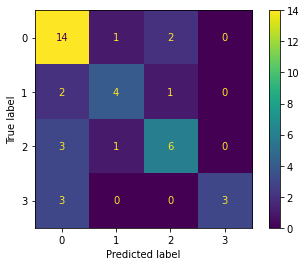

In [12]:
model = svm.LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(list(zip(y_pred, y_test)))
print((y_pred == y_test).sum() / len(y_test))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [13]:
class Dataset:
    def __init__(self, X: np.ndarray, y: np.ndarray, batch_size: int = 64):
        self.X = X
        self.y = y
        self.num_samples, self.num_features = X.shape
        self.batch_size = batch_size
        self.inds = np.arange(self.num_samples)

    def __len__(self):
        return self.num_samples

    def set_batch_size(self, batch_size: int):
        self.batch_size = batch_size

    def shuffle(self):
        self.inds = np.random.permutation(self.num_samples)

    def __iter__(self):
        if self.batch_size is None:
            return self.X[self.inds], self.y[self.inds]
        start = 0
        while start < len(self):
            stop = min(start + self.batch_size, self.num_samples)
            inds = self.inds[start:stop]
            yield self.X[inds], self.y[inds]
            start = stop

In [14]:
class Perceptron(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.flatten = nn.Flatten()
        self.stack = nn.Sequential(
            nn.Linear(num_features, num_classes),
            nn.Softmax()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.stack(x)

In [15]:
BATCH_SIZE = 16
LEARNING_RATE = 1e-3
EPOCHS = 1500

train_dataset = Dataset(X_train.todense(), y_train, batch_size=BATCH_SIZE)
TRAIN_SIZE = X_train.shape[0]
NUM_CLASSES = len(np.unique(y_train))

# choose device and initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Perceptron(
    num_features=X_train.shape[1],
    num_classes=NUM_CLASSES
)
model = model.to(device)

# train the model
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
train_losses = np.zeros(EPOCHS)
train_acc = np.zeros_like(train_losses)
test_losses = np.zeros_like(train_losses)
test_acc = np.zeros_like(train_losses)
loss_function = nn.NLLLoss()
X_test = torch.tensor(X_test.todense(), dtype=torch.float32, device=device)
y_test = torch.tensor(y_test, dtype=torch.uint8, device=device)

for i in range(EPOCHS):

    # train loop
    mean_loss = 0.0
    true_count = 0
    for X_j, y_j in train_dataset:
        X_j = torch.tensor(X_j, dtype=torch.float32, device=device)
        y_j = torch.tensor(y_j, dtype=torch.int64, device=device)
        y_pred = model.forward(X_j)
        loss = loss_function(y_pred, y_j)
        mean_loss += loss.item() * X_j.shape[0] / TRAIN_SIZE
        predictions = torch.argmax(y_pred, axis=1)
        true_count += (predictions == y_j).sum()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_dataset.shuffle()
    train_losses[i] = mean_loss
    train_acc[i] = true_count / TRAIN_SIZE

    # test / validation
    with torch.no_grad():
        y_pred = model.forward(X_test)
        test_losses[i] = loss_function(y_pred, y_test).item()
        pred = torch.argmax(y_pred, axis=1)
        test_acc[i] = (pred == y_test).sum() / len(y_test)

    # display progress
    print('\rEpoch {:4d}, train loss = {:.3f}, test loss = {:.3f}'.format(
            i + 1, train_losses[i], test_losses[i]
            ), end='')

print('\nComplete')

print(list(zip(pred.cpu().numpy(), y_test.cpu().numpy())))

/home/vsg/virtualenvs/torch/lib/python3.9/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 1500, train loss = -0.977, test loss = -0.636
Complete
[(0, 2), (0, 3), (1, 1), (0, 0), (1, 1), (0, 0), (0, 2), (3, 3), (0, 0), (0, 1), (0, 0), (0, 0), (0, 2), (0, 0), (2, 2), (1, 2), (2, 2), (0, 1), (0, 3), (1, 2), (2, 2), (0, 0), (2, 0), (1, 0), (0, 0), (0, 0), (1, 1), (2, 2), (0, 0), (0, 0), (1, 0), (3, 1), (2, 0), (3, 3), (0, 0), (2, 2), (3, 3), (0, 0), (0, 3), (1, 1)]


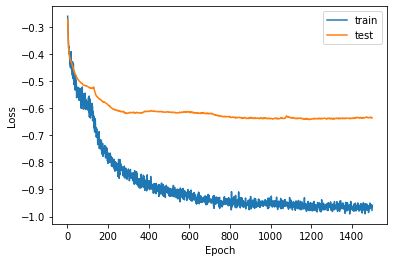

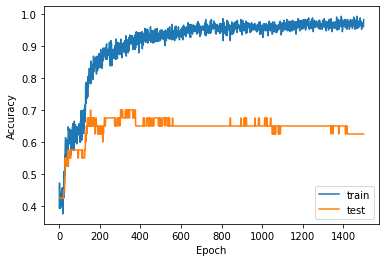

In [16]:
# plot results
epochs = np.arange(1, EPOCHS + 1)
plt.figure()
plt.plot(epochs, train_losses, label='train')
plt.plot(epochs, test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.figure()
plt.plot(epochs, train_acc, label='train')
plt.plot(epochs, test_acc, label='test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

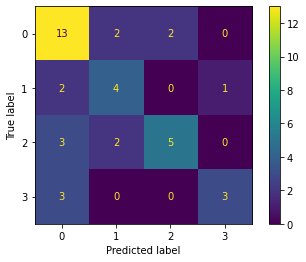

In [17]:
pred = np.argmax(y_pred.cpu().numpy(), axis=1)

ConfusionMatrixDisplay.from_predictions(y_test.cpu().numpy(), pred)

In [ ]:
pred = np.argmax(y_pred.cpu().numpy(), axis=1)
pred